## About Time Series Forecasting

In this chapter we introduce and define the problem of forecasting time series, discuss how to properly evaluate the performance of a forecasting model, and get to know some metrics to quantify the performance.

## Preamble

In [1]:
%matplotlib inline

In [4]:
import pandas
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import numpy

In [8]:
import forecast_lab

In [9]:
seaborn.set_style("ticks")
matplotlib.pyplot.rcParams["axes.grid"] = True
matplotlib.pyplot.rcParams["figure.figsize"] = (20, 3)

## For Example: Forecasting Taxi Demand

Consider for example the problem of forecasting demand for taxi rides in a city. Based on [a public dataset from the City of Chicago](https://catalog.data.gov/dataset/taxi-trips), we have extracted a time series of the the number of taxi trips per day. This time series has several realistic properties, such as seasonal (e.g. weekly) patterns and a non-trivial trend.

In [10]:
taxi_trips = forecast_lab.datasets.read_chicago_taxi_trips_daily()

In [11]:
taxi_trips.head()

,Trips
Date,
2013-01-01,96
2013-01-02,53
2013-01-03,61
2013-01-04,79
2013-01-05,76


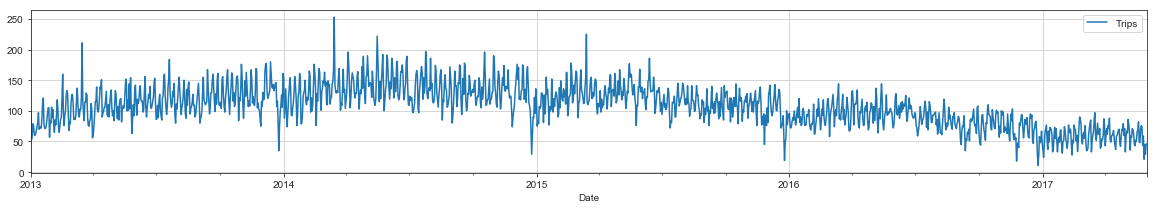

In [12]:
taxi_trips.plot()

In the following, we are going to have a look at various statistical modelling and machine learning techniques that can be applied to forecasting a time series like this.

## Forecasting Concepts

**A Forecast's Horizon**

An important question to ask before building a forecast model: How far into the future do we need to look? The number of steps to forecast is called the forecast's **horizon**.


A true forecasting model has the ability ability to **predict a time series $h$ steps ahead**, for the desired number of steps $h$. (This is a more difficult task than **one-step-ahead** prediction - given the previous $k$ points of the time series, predict the next value, which can be solved by supervised ML methods we already know at this point.)


**Recursive and Direct Forecasting**


We need to distinguish two different approaches to forecasting this:
- **recursive forecasting**: The model has the ability to predict one step ahead - now we apply it recursively on its own predictions to forecast $h$ steps ahead.
- **direct forecasting**: The model can directly predict the next $h$ steps without recursively using its own predictions as input.



## Evaluating Forecasting Models

How good is the performance of my forecasting model? How do I set up an evaluation in order to produce a model that works in practice? This section introduces:

- **error metrics for time series forecasts**
- **splitting into training and test data**

### Metrics

In general, a performance/error metric is a function $M$ that takes  actual values of the time series $y$ and the coresponding forecasted values $\hat{y}$.

$$M(y, \hat{y}) = \dots$$

Measuring the error in time series forecasting is in many ways similar to how we do it with classical **regression** problems, so let's revisit the error metrics discussed in [📓 Machine Learning with Python: About Regression](../ml/ml-regression-intro.ipynb).

- **Mean Absolute Error (MAE)**
- **Root Mean Squared Error (RMSE)**
- **$R^2$ score**
- **Mean Absolute Percentage Error (MAPE)**


### Business Case-Specific Metrics

While the general error metrics above are widely applicable, a metric specific to your business case for forecasting is even more appropriate and interpretable. It pays to spend some time on designing an appropriate performance metric - perhaps the error can be numbered in monetary terms, connected to an important KPI, etc. 

**Exercise: Pick a real-life forecasting problem, then brainstorm and discuss specific metrics that could be relevant!**

### Splitting the Data for Evaluation

At this point we assume you already know about evaluation strategies like **train-test-split** and **cross-validation** and why they are necessary. You can read up on this in [📓 Machine Learning with Python: About Classification](../ml/ml-classification-intro.ipynb).

When dealing with time series, we have to approach things somewhat differently: Here, randomly shuffling and splitting of the data points does not make sense. Rather, we want to use a past segment of the time series to predict a future segment.

How large should these segments be? This is very much dependent on our application and use case. How far into the future do we need to look to make good decisions for our business case? What is more important - short-term or long-term accuracy? 

#### A Helper Class for Forecast Evaluation

We have prepared some code to make evaluation of forecast performance more convenient: The `ForecastEvaluation` implements a couple of training and evaluation strategies. Here, we use it to:

1. Perform evaluation similar to _cross-validation_: Split the time series randomly into a training and adjacent test segment of given sizes. Fit the model to the training segment and forecast the test segment.
2. Evaluate the performance of the forecast through the given metrics.
3. Plot the forecast and diagnostic information.

In [13]:
metrics = {
    "RMSE": forecast_lab.metrics.root_mean_squared_error,
    "MAPE": forecast_lab.metrics.mean_absolute_percentage_error
}

In [14]:
import statsmodels.api as sm

Our `mlts` module also provides a few wrapper classes so that we can evaluate forecasting with different approaches and libraries. For example, the `StatsmodelsWrapper` is used to package a `statsmodels`-style time series model. Note the parameters:

- `estimator_params`: supplied to the constructor of the `estimator_class`
- `fit_params`: supplied to the `fit` method call

======== iteration 0 ==========


/Users/cls/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cls/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/cls/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


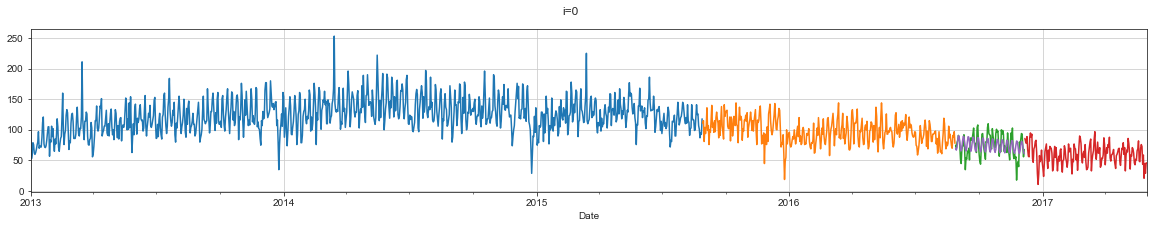

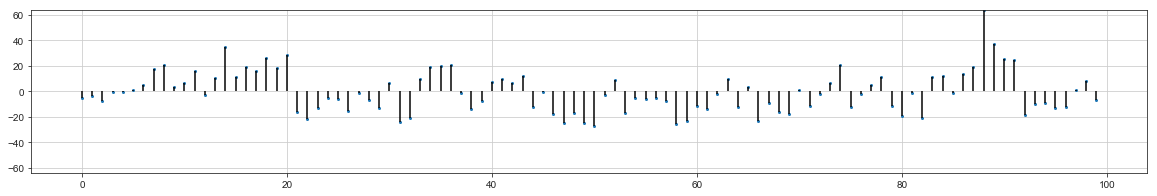

======== iteration 1 ==========


/Users/cls/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/cls/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:191: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  start=index[0], end=index[-1], freq=freq)
/Users/cls/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


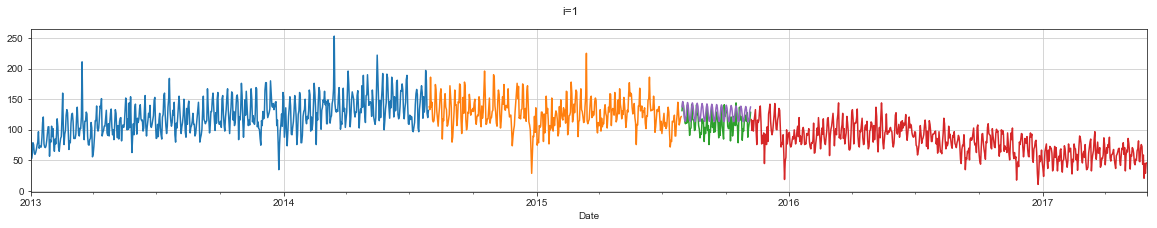

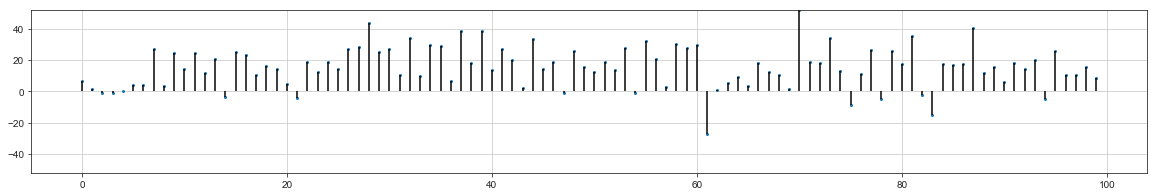

MAPE    19.001681
RMSE    18.129693
dtype: float64

In [18]:
forecast_lab.ForecastEvaluation(
    ts=taxi_trips["Trips"],
    metrics=metrics,
    forecasting=forecast_lab.StatsmodelsWrapper(
        estimator_class=sm.tsa.ARIMA,
        estimator_params={
            "order": (4,1,2)
        },
        fit_params={
            "max_iter": 10
        },
    ),
    train_window_size=365,
    test_window_size=100,
).evaluate(
    k=2,
    plot_segments=True,
    plot_residuals=True,
).get_metrics().mean()

## Dummy Models

When spending time on a sophisticated forecast using statistical modelling and machine learning, there is a good question that we should have an answer to: How does it compare to simple, "trivial" forecasts? We should be able to get significantly better performance to justify the engineering that goes into any ML-based solution.

Here are implementations a few **dummy models** that are really simple, but can be surprisingly hard to beat with more advanced techniques.

In [19]:
forecast_lab.dummy.MeanForecast??

Init signature: forecast_lab.dummy.MeanForecast()
Source:        
class MeanForecast:
    """Forecasts the mean of the time series"""

    def fit(self, ts, ext_vars=None):
        self.mean = numpy.mean(ts)
        return self

    def forecast(self, steps, ext_vars=None):
        return numpy.full(steps, self.mean)
File:           ~/Documents/Freelancing/Projects/point8/DataScience101/forecast-lab/forecast_lab/dummy.py
Type:           type
Subclasses:     


In [20]:
forecast_lab.dummy.LinearForecast??

Init signature: forecast_lab.dummy.LinearForecast()
Source:        
class LinearForecast:
    """
    Fits a linear function to the given time series and extrapolates it for the forecast.
    """

    def fit(self, ts, ext_vars):
        slope, intercept, _, _, _ = scipy.stats.linregress(numpy.arange(len(ts)), ts)
        self.slope = slope
        self.intercept = intercept
        return self

    def forecast(self, steps, ext_vars=None):
        return self.slope * numpy.arange(steps) + self.intercept
File:           ~/Documents/Freelancing/Projects/point8/DataScience101/forecast-lab/forecast_lab/dummy.py
Type:           type
Subclasses:     


======== iteration 0 ==========


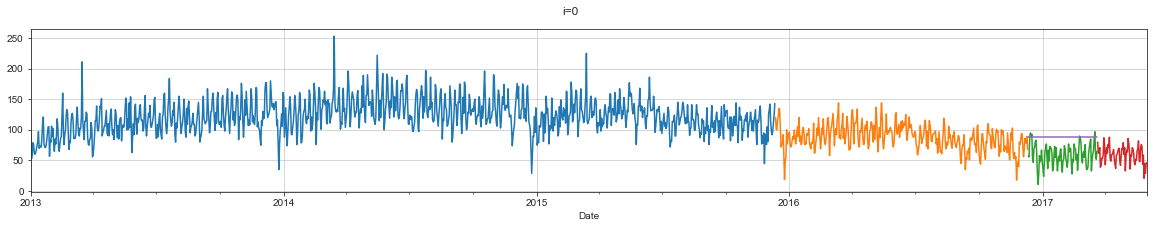

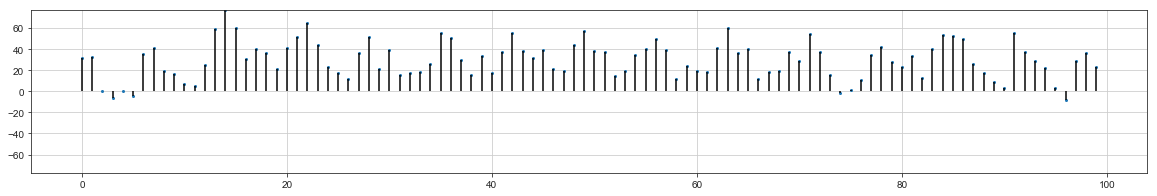

======== iteration 1 ==========


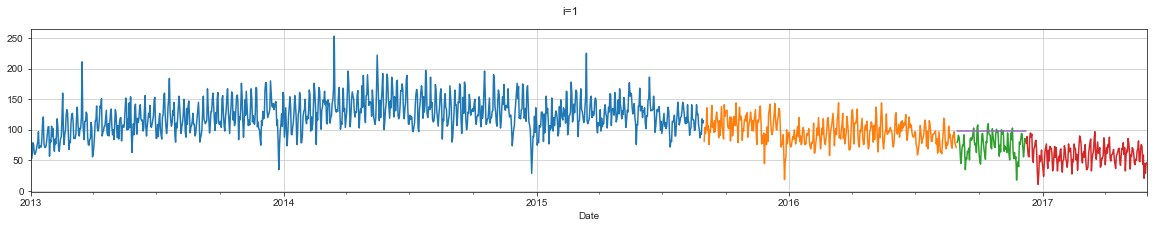

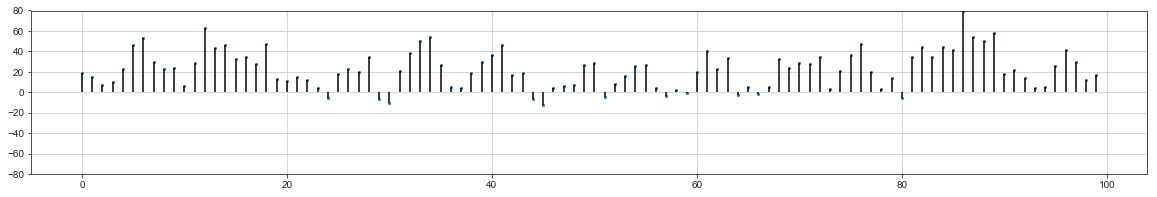

,MAPE,RMSE
0,70.701771,34.320268
1,41.797197,28.803711


In [26]:
forecast_lab.ForecastEvaluation(
    ts=taxi_trips["Trips"],
    metrics=metrics,
    forecasting=forecast_lab.dummy.MeanForecast(),
    train_window_size=365,
    test_window_size=100,
).evaluate(
    k=2,
    plot_segments=True,
    plot_residuals=True
).get_metrics()

======== iteration 0 ==========


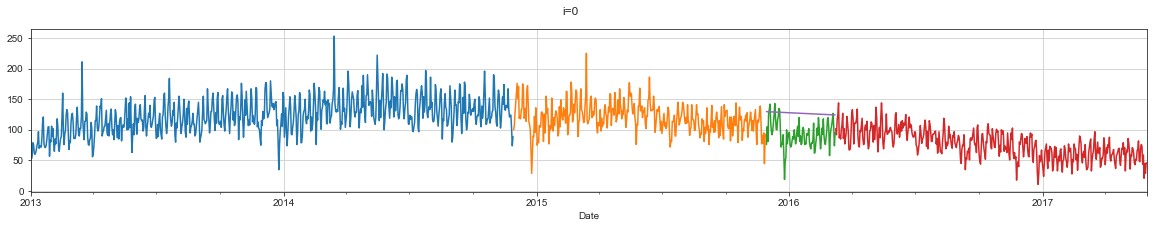

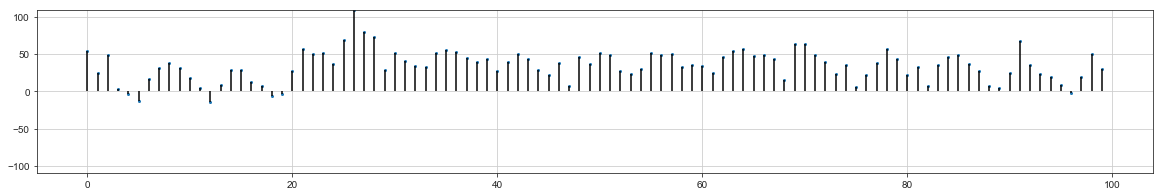

======== iteration 1 ==========


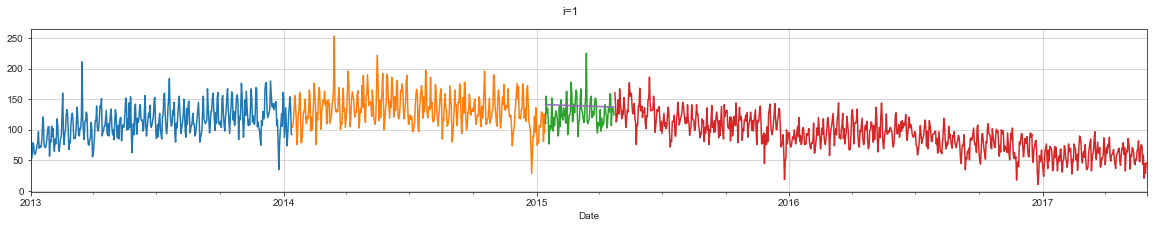

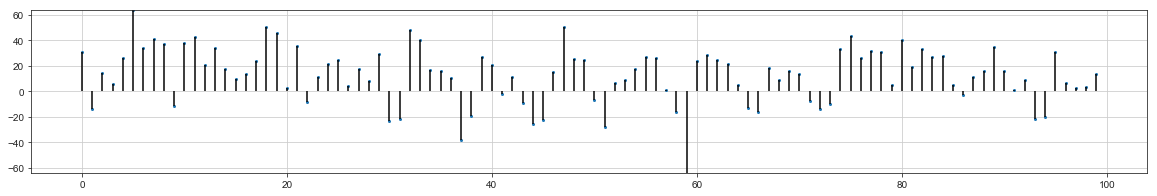

MAPE    33.263037
RMSE    32.970072
dtype: float64

In [25]:
forecast_lab.ForecastEvaluation(
    ts=taxi_trips["Trips"],
    metrics=metrics,
    forecasting=forecast_lab.dummy.LinearForecast(),
    train_window_size=365,
    test_window_size=100,
).evaluate(
    k=2,
    plot_segments=True,
    plot_residuals=True
).get_metrics().mean()

## References

- [Forecasting - Metrics for Time Series Forecasts](https://www.edscave.com/forecasting---time-series-metrics.html)
- [Recursive and Direct Forecasting](https://stats.stackexchange.com/questions/346714/forecasting-several-periods-with-machine-learning)
- [Simple Forecast Methods](https://otexts.com/fpp2/simple-methods.html)

---
_This notebook is licensed under a [Creative Commons Attribution 4.0 International License (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/). Copyright © 2019 [Point 8 GmbH](https://point-8.de)_

